# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import os
import pandas as pd
from typing import Dict
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-12-03 01:17:25,028 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_simulated_weekly.csv"
)

dt_prophet_holidays = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_prophet_holidays.csv"
)

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    hyperparameters={
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-12-03 01:17:26,500 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-12-03 01:17:26,502 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-12-03 01:17:26,502 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/data/entities/mmmdata.py:259: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = ~selected_columns.applymap(
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
202

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt

%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(
    mmm_data, hyperparameters, featurized_mmmdata=featurized_mmm_data
)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result.get("channel")
    print(f"Processing channel: {channel}")  # Debugging line
    if not channel:
        print(f"Skipping invalid channel: {result}")
        continue

    try:
        fig = feature_plotter.plot_spend_exposure(channel)
        plt.show()
    except ValueError as e:
        print(f"Error plotting {channel}: {str(e)}")

2024-12-03 01:17:27,166 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-03 01:17:27,167 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-03 01:17:27,167 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-12-03 01:17:27,167 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-12-03 01:17:27,168 - robyn.visualization.feature_visualization - INFO - Found result for channel facebook_I
2024-12-03 01:17:27,318 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I
2024-12-03 01:17:27,318 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-12-03 01:17:27,318 - robyn.visualization.feature_visualization - INFO - Found result for channel search_clicks_P


Processing channel: facebook_I
Processing channel: search_clicks_P


2024-12-03 01:17:27,457 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


In [9]:
print(featurized_mmm_data.modNLS["plots"].keys())

for result in featurized_mmm_data.modNLS["results"]:
    print(result.get("channel"))

dict_keys(['facebook_I', 'search_clicks_P'])
facebook_I
search_clicks_P


In [10]:
plot_data = featurized_mmm_data.modNLS["plots"].get("facebook_I")
print(plot_data)

           spend      exposure          yhat
6    3623.012233  1.371590e+07  1.404919e+07
7    4129.816153  1.885156e+07  1.595491e+07
8    3623.012233  1.191019e+07  1.404919e+07
9    3002.690585  1.062042e+07  1.169716e+07
10      0.000000  0.000000e+00  0.000000e+00
..           ...           ...           ...
158     0.000000  0.000000e+00  0.000000e+00
159     0.000000  0.000000e+00  0.000000e+00
160     0.000000  0.000000e+00  0.000000e+00
161  9068.007406  3.220052e+07  3.380801e+07
162     0.000000  0.000000e+00  0.000000e+00

[157 rows x 3 columns]


In [11]:
import numpy as np


# For MMM Data
def debug_mmm_data(mmm_data):
    print("=== MMM Data Debug ===")
    print("\nMMM Data Specification:")
    print(f"Dependent Variable: {mmm_data.mmmdata_spec.dep_var}")
    print(f"Paid Media Spends: {mmm_data.mmmdata_spec.paid_media_spends}")
    print(f"Paid Media Vars: {mmm_data.mmmdata_spec.paid_media_vars}")
    print(f"Organic Vars: {mmm_data.mmmdata_spec.organic_vars}")


# For Hyperparameters
def debug_hyperparameters(hyperparameters):
    print("=== Hyperparameters Debug ===")
    print("\nHyperparameters structure:")
    for channel, params in hyperparameters.hyperparameters.items():
        print(f"\nChannel: {channel}")
        print("Thetas:", getattr(params, "thetas", None))
        print("Alphas:", getattr(params, "alphas", None))
        print("Gammas:", getattr(params, "gammas", None))
        print("Shapes:", getattr(params, "shapes", None))
        print("Scales:", getattr(params, "scales", None))

    print("\nLambda:", hyperparameters.lambda_)
    print("Train size:", hyperparameters.train_size)


# For Featurized MMM Data
def debug_featurized_data(featurized_mmm_data):
    print("=== Featurized MMM Data Debug ===")
    print("\nFeaturized data shape:", featurized_mmm_data.dt_mod.shape)
    print("\nFeaturized data columns:", featurized_mmm_data.dt_mod.columns.tolist())

    # Basic statistics of the featurized data
    print("\nFeaturized data statistics:")
    print(featurized_mmm_data.dt_mod.describe())

    # Check for any transformations that occurred
    print("\nData types:")
    print(featurized_mmm_data.dt_mod.dtypes)

    # Check for any missing or infinite values
    print("\nMissing values count:")
    print(featurized_mmm_data.dt_mod.isnull().sum())
    print("\nInfinite values count:")
    print(np.isinf(featurized_mmm_data.dt_mod.select_dtypes(include=np.number)).sum())


# Combined debug function
def debug_all_inputs(mmm_data, hyperparameters, featurized_mmm_data):
    debug_mmm_data(mmm_data)
    print("\n" + "=" * 50 + "\n")
    debug_hyperparameters(hyperparameters)
    print("\n" + "=" * 50 + "\n")
    debug_featurized_data(featurized_mmm_data)


# Usage:
debug_all_inputs(mmm_data, hyperparameters, featurized_mmm_data)

=== MMM Data Debug ===

MMM Data Specification:
Dependent Variable: revenue
Paid Media Spends: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
Paid Media Vars: ['tv_S', 'ooh_S', 'print_S', 'facebook_I', 'search_clicks_P']
Organic Vars: ['newsletter']


=== Hyperparameters Debug ===

Hyperparameters structure:

Channel: facebook_S
Thetas: [0, 0.3]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: print_S
Thetas: [0.1, 0.4]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: tv_S
Thetas: [0.3, 0.8]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: search_S
Thetas: [0, 0.3]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: ooh_S
Thetas: [0.1, 0.4]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: newsletter
Thetas: [0.1, 0.4]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Lambda: [0, 1]
Train size: [0.5, 0.8]


=== Featurized MMM Data Debug ===

Featurized data shape: (20

2024-12-03 01:17:27,514 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-12-03 01:17:27,515 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-12-03 01:17:27,515 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-12-03 01:17:27,515 - robyn.common.common_util - WARNING - Requested cores (16) exceeds available cores (10). Will use 10 cores.
2024-12-03 01:17:27,516 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-12-03 01:17:27,516 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-12-03 01:17:27,516 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-12-03 01:17:27,516 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-12-03 01:17:27,517 - robyn.modeling.ridge.ridge_data_builder - INFO - Collecting hyperparameters for opt

>>> Starting 1 trials with 2000 iterations each using TwoPointsDE nevergrad algorithm on x cores...


Running trial 1 of total 1 trials:   0%|                                   


Pre-lambda calculation debug (iteration 0):
x_norm shape: (143, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 6.63178285e-09  1.71549446e+06  1.12639949e+06 -1.59237714e-08
  8.12500900e+06  5.52537113e-09  1.40531834e-01 -1.35147746e-08
  3.45488906e-01  4.70500032e-01 -6.46212057e-09  1.94016538e+04]
y_norm shape: (143,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.2835963773323633, 'facebook_S_alphas': 1.8435644690538955, 'facebook_S_gammas': 0.5188954920312618, 'print_S_thetas': 0.34703050960488074, 'print_S_alphas': 2.006508497068446, 'print_S_gammas': 0.5127114369662895, 'tv_S_thetas': 0.7124628364956679, 'tv_S_alphas': 1.0341682240607177, 'tv_S_gammas': 0.5641327143712191, 'search_S_thetas': 0.2657160403908986, 'search_S_alphas': 2.9593932808464682, 'search

Running trial 1 of total 1 trials:   3%|▉                                  


Pre-lambda calculation debug (iteration 50):
x_norm shape: (157, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-7.53695890e-09  1.71549446e+06  1.12639949e+06  9.63308404e-10
  8.12500900e+06 -6.38394030e-09  9.12620152e-02  1.18331498e-08
  1.12793433e-01  7.72787003e-01 -2.53055406e-09  1.94016538e+04]
y_norm shape: (157,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.0004228960540156866, 'facebook_S_alphas': 2.5103861230580367, 'facebook_S_gammas': 0.30333208670403156, 'print_S_thetas': 0.37127768010207096, 'print_S_alphas': 2.8712923908029038, 'print_S_gammas': 0.7572974197050062, 'tv_S_thetas': 0.4140531570659749, 'tv_S_alphas': 1.2570309424725514, 'tv_S_gammas': 0.869693413340006, 'search_S_thetas': 0.1670446365703638, 'search_S_alphas': 0.9317512558555462, 's

Running trial 1 of total 1 trials:   5%|█▊                                 


Pre-lambda calculation debug (iteration 100):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 4.76534852e-09  1.71549446e+06  1.12639949e+06  5.27822395e-09
  8.12500900e+06 -3.99203646e-09  1.44267510e-01 -1.27930665e-08
  2.83026959e-01  4.40117470e-01 -1.10941039e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.21661422149228504, 'facebook_S_alphas': 1.0884257051703974, 'facebook_S_gammas': 0.6108819987781148, 'print_S_thetas': 0.34830453396641287, 'print_S_alphas': 1.168410380556792, 'print_S_gammas': 0.8257629581624448, 'tv_S_thetas': 0.7865377667932533, 'tv_S_alphas': 0.7281024295060039, 'tv_S_gammas': 0.8176973222248581, 'search_S_thetas': 0.2490338579197045, 'search_S_alphas': 2.8661037432664282, 'sea

Running trial 1 of total 1 trials:   8%|██▋                                


Pre-lambda calculation debug (iteration 150):
x_norm shape: (152, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-1.06070682e-08  1.71549446e+06  1.12639949e+06 -4.49883237e-09
  8.12500900e+06 -5.20476083e-09  2.19729151e-01  1.31898609e-08
  1.35145875e-01  4.13656825e-01 -1.36723274e-08  1.94016538e+04]
y_norm shape: (152,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.10734655659563422, 'facebook_S_alphas': 0.5534821128486818, 'facebook_S_gammas': 0.9257707249462123, 'print_S_thetas': 0.13560432867295566, 'print_S_alphas': 2.006508497068446, 'print_S_gammas': 0.9954543899095374, 'tv_S_thetas': 0.6374993123761288, 'tv_S_alphas': 0.9275189988003684, 'tv_S_gammas': 0.4496886987430767, 'search_S_thetas': 0.04338530511139745, 'search_S_alphas': 2.9855654429868093, 'se

Running trial 1 of total 1 trials:  10%|███▌                               


Pre-lambda calculation debug (iteration 200):
x_norm shape: (164, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 1.70916853e-08  1.71549446e+06  1.12639949e+06 -2.87104916e-09
  8.12500900e+06 -4.30082912e-09  1.79347783e-01 -1.07932102e-08
  9.79930667e-02  5.70507551e-01  1.56715921e-08  1.94016538e+04]
y_norm shape: (164,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.04936441516933761, 'facebook_S_alphas': 0.8036004323795161, 'facebook_S_gammas': 0.34677755493808016, 'print_S_thetas': 0.2936716405645528, 'print_S_alphas': 2.47524761196034, 'print_S_gammas': 0.9319020454281822, 'tv_S_thetas': 0.7950735209656963, 'tv_S_alphas': 0.6978973006745957, 'tv_S_gammas': 0.5866599684995601, 'search_S_thetas': 0.24280199330311358, 'search_S_alphas': 2.9071343218601178, 'sea

Running trial 1 of total 1 trials:  13%|████▍                              


Pre-lambda calculation debug (iteration 250):
x_norm shape: (158, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 2.86018019e-09  1.71549446e+06  1.12639949e+06  1.21252768e-08
  8.12500900e+06  1.06952810e-08  1.29491532e-01 -2.70177989e-10
  2.50579119e-01  5.41667973e-01 -6.54692220e-10  1.94016538e+04]
y_norm shape: (158,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.21661422149228504, 'facebook_S_alphas': 0.6940014056145604, 'facebook_S_gammas': 0.38492676151514243, 'print_S_thetas': 0.3462069860638603, 'print_S_alphas': 1.168410380556792, 'print_S_gammas': 0.9526316694489618, 'tv_S_thetas': 0.7865377667932534, 'tv_S_alphas': 0.7792958322749514, 'tv_S_gammas': 0.8176973222248581, 'search_S_thetas': 0.28085141230713206, 'search_S_alphas': 2.7745813926993748, 'se

Running trial 1 of total 1 trials:  15%|█████▎                             


Pre-lambda calculation debug (iteration 300):
x_norm shape: (118, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-8.93874507e-09  1.71549446e+06  1.12639949e+06  1.24231432e-08
  8.12500900e+06 -5.99521117e-10  2.44789513e-01 -7.20470165e-09
  1.35145879e-01  4.51374006e-01 -8.28084082e-09  1.94016538e+04]
y_norm shape: (118,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.1822345055594355, 'facebook_S_alphas': 1.6742893971195385, 'facebook_S_gammas': 0.5516090080947937, 'print_S_thetas': 0.13560432867295566, 'print_S_alphas': 2.006508497068446, 'print_S_gammas': 0.9954543899095374, 'tv_S_thetas': 0.7179058388882575, 'tv_S_alphas': 0.6278092183050522, 'tv_S_gammas': 0.5801912591659564, 'search_S_thetas': 0.10022007709464803, 'search_S_alphas': 2.9855654429868093, 'sea

Running trial 1 of total 1 trials:  18%|██████▏                            


Pre-lambda calculation debug (iteration 350):
x_norm shape: (161, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [6.70450800e-09 1.71549446e+06 1.12639949e+06 9.92542908e-09
 8.12500900e+06 7.56767356e-09 1.24674292e-01 5.73967591e-11
 1.15598767e-01 5.36429616e-01 3.35049667e-09 1.94016538e+04]
y_norm shape: (161,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.02445347514008053, 'facebook_S_alphas': 0.5270163578306657, 'facebook_S_gammas': 0.37440943713214464, 'print_S_thetas': 0.37139862749602576, 'print_S_alphas': 2.1743373044557175, 'print_S_gammas': 0.9412411425286566, 'tv_S_thetas': 0.7107658629491823, 'tv_S_alphas': 0.8719482067028391, 'tv_S_gammas': 0.9196369907494506, 'search_S_thetas': 0.25601672046215673, 'search_S_alphas': 1.7195242660069656, 'search_S_gam

Running trial 1 of total 1 trials:  20%|███████                            


Pre-lambda calculation debug (iteration 400):
x_norm shape: (161, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-9.26047587e-09  1.71549446e+06  1.12639949e+06 -1.13306473e-08
  8.12500900e+06  6.44732637e-09  1.94804628e-01 -9.70352415e-09
  1.57822561e-01  4.41369569e-01 -2.08988461e-09  1.94016538e+04]
y_norm shape: (161,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.05356200419809645, 'facebook_S_alphas': 0.7670303374810012, 'facebook_S_gammas': 0.6712099157649185, 'print_S_thetas': 0.33093391071542355, 'print_S_alphas': 1.7451378086957223, 'print_S_gammas': 0.9794216997609402, 'tv_S_thetas': 0.7500264831285888, 'tv_S_alphas': 0.6719868275018349, 'tv_S_gammas': 0.7134710028899257, 'search_S_thetas': 0.2512626945375875, 'search_S_alphas': 2.828224094068674, 'sea

Running trial 1 of total 1 trials:  23%|███████▉                           


Pre-lambda calculation debug (iteration 450):
x_norm shape: (158, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-3.62450605e-09  1.71549446e+06  1.12639949e+06 -1.24344539e-08
  8.12500900e+06  7.93486541e-09  1.64940363e-01 -1.32652344e-08
  8.06081721e-02  4.51373991e-01 -1.26205540e-08  1.94016538e+04]
y_norm shape: (158,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.1822345055594355, 'facebook_S_alphas': 1.6742893971195385, 'facebook_S_gammas': 0.5516090080947937, 'print_S_thetas': 0.26320564208492025, 'print_S_alphas': 2.787427791445863, 'print_S_gammas': 0.9188786150656226, 'tv_S_thetas': 0.7911351815509924, 'tv_S_alphas': 0.7066498862821051, 'tv_S_gammas': 0.6801982898698731, 'search_S_thetas': 0.2174927672625172, 'search_S_alphas': 2.939494350338698, 'searc

Running trial 1 of total 1 trials:  25%|████████▊                          


Pre-lambda calculation debug (iteration 500):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 5.49707612e-09  1.71549446e+06  1.12639949e+06 -2.38855022e-09
  8.12500900e+06  1.24540723e-08  8.28945357e-02 -1.12839941e-08
  1.40499513e-01  5.45924443e-01  6.65615971e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.0331905808571684, 'facebook_S_alphas': 0.5004640367397611, 'facebook_S_gammas': 0.3417747762884261, 'print_S_thetas': 0.17270818477228542, 'print_S_alphas': 2.7356351342256375, 'print_S_gammas': 0.7603909419799822, 'tv_S_thetas': 0.751875363380469, 'tv_S_alphas': 1.0011956996579763, 'tv_S_gammas': 0.9452520159206304, 'search_S_thetas': 0.2313953500225292, 'search_S_alphas': 2.9633604647265046, 'sear

Running trial 1 of total 1 trials:  28%|█████████▋                         


Pre-lambda calculation debug (iteration 550):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-3.32888342e-09  1.71549446e+06  1.12639949e+06  5.43877456e-10
  8.12500900e+06  5.18041997e-09  1.75877366e-01  5.56587374e-11
  6.35285276e-02  5.25315987e-01 -2.36954108e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.016486036825658096, 'facebook_S_alphas': 0.9028571711653197, 'facebook_S_gammas': 0.4414844754067357, 'print_S_thetas': 0.35046289501581557, 'print_S_alphas': 2.7823715294397973, 'print_S_gammas': 0.9794216997609401, 'tv_S_thetas': 0.7193933211327573, 'tv_S_alphas': 0.6887303899594948, 'tv_S_gammas': 0.9042513226796106, 'search_S_thetas': 0.2542349942261062, 'search_S_alphas': 2.9116814819670895, 's

Running trial 1 of total 1 trials:  30%|██████████▌                        


Pre-lambda calculation debug (iteration 600):
x_norm shape: (158, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 6.13720658e-09  1.71549446e+06  1.12639949e+06 -1.54418198e-08
  8.12500900e+06 -3.58589603e-09  1.72067115e-01 -1.40664537e-09
  8.06081364e-02  6.12506163e-01 -2.42920585e-09  1.94016538e+04]
y_norm shape: (158,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.04587709048034634, 'facebook_S_alphas': 1.0409577556176604, 'facebook_S_gammas': 0.3180516734875592, 'print_S_thetas': 0.26320564208492025, 'print_S_alphas': 2.787427791445863, 'print_S_gammas': 0.9188786150656226, 'tv_S_thetas': 0.7861774096135077, 'tv_S_alphas': 0.719822676863289, 'tv_S_gammas': 0.6304885057535287, 'search_S_thetas': 0.2174927672625172, 'search_S_alphas': 2.939494350338698, 'searc

Running trial 1 of total 1 trials:  33%|███████████▍                       


Pre-lambda calculation debug (iteration 650):
x_norm shape: (160, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-1.57914539e-08  1.71549446e+06  1.12639949e+06 -1.93901959e-08
  8.12500900e+06 -4.47405360e-09  1.68347838e-01 -1.59277719e-08
  9.02968766e-02  5.65050428e-01 -1.46271123e-08  1.94016538e+04]
y_norm shape: (160,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.012381822346259836, 'facebook_S_alphas': 0.9999721730239078, 'facebook_S_gammas': 0.380211649475785, 'print_S_thetas': 0.3130434428644345, 'print_S_alphas': 2.528683795262196, 'print_S_gammas': 0.9414434419422018, 'tv_S_thetas': 0.751875363380469, 'tv_S_alphas': 0.8075276050591416, 'tv_S_gammas': 0.6194197919606209, 'search_S_thetas': 0.2689830813724102, 'search_S_alphas': 2.7568605503273798, 'searc

Running trial 1 of total 1 trials:  35%|████████████▎                      


Pre-lambda calculation debug (iteration 700):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 1.22187057e-08  1.71549446e+06  1.12639949e+06 -2.93306967e-09
  8.12500900e+06  1.53022783e-10  1.52369189e-01  9.49183612e-10
  6.35285278e-02  5.73221854e-01 -1.66148061e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.00040294547987347314, 'facebook_S_alphas': 1.019285472218382, 'facebook_S_gammas': 0.3698220315784304, 'print_S_thetas': 0.35046289501581557, 'print_S_alphas': 2.7823715294397973, 'print_S_gammas': 0.9794216997609401, 'tv_S_thetas': 0.7814592471991586, 'tv_S_alphas': 0.6887303899594944, 'tv_S_gammas': 0.88693312141304, 'search_S_thetas': 0.2542349942261062, 'search_S_alphas': 2.9116814819670895, 'se

Running trial 1 of total 1 trials:  38%|█████████████▏                     


Pre-lambda calculation debug (iteration 750):
x_norm shape: (160, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-4.08949881e-09  1.71549446e+06  1.12639949e+06  6.18123936e-09
  8.12500900e+06 -2.53386329e-08  1.84687741e-01 -3.17157573e-09
  7.83516329e-02  5.86733698e-01  9.68745170e-09  1.94016538e+04]
y_norm shape: (160,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.04587709048034634, 'facebook_S_alphas': 1.0974850658816822, 'facebook_S_gammas': 0.35878044569643497, 'print_S_thetas': 0.37319379661254126, 'print_S_alphas': 2.622906310344499, 'print_S_gammas': 0.9442607562919288, 'tv_S_thetas': 0.7707054723288992, 'tv_S_alphas': 0.7988116757295817, 'tv_S_gammas': 0.5023017729692268, 'search_S_thetas': 0.08384747409165293, 'search_S_alphas': 2.9832379117957344, 's

Running trial 1 of total 1 trials:  40%|██████████████                     


Pre-lambda calculation debug (iteration 800):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 7.76402111e-09  1.71549446e+06  1.12639949e+06  2.32274847e-08
  8.12500900e+06  6.60730558e-09  3.08370122e-01  4.01208516e-09
  6.60593749e-02  4.92458632e-01 -1.91219689e-08  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.05546674417383184, 'facebook_S_alphas': 0.768683721187278, 'facebook_S_gammas': 0.5134349936158454, 'print_S_thetas': 0.39684739112575046, 'print_S_alphas': 2.796582317779441, 'print_S_gammas': 0.9414434419422018, 'tv_S_thetas': 0.7286171633574834, 'tv_S_alphas': 0.5506084691592564, 'tv_S_gammas': 0.40471350928732436, 'search_S_thetas': 0.007292449021347955, 'search_S_alphas': 2.895030657626529, 'se

Running trial 1 of total 1 trials:  43%|██████████████▉                    


Pre-lambda calculation debug (iteration 850):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-5.28164706e-09  1.71549446e+06  1.12639949e+06  3.70189166e-09
  8.12500900e+06 -3.99770591e-09  2.47416217e-01 -7.57095005e-09
  1.13446883e-01  5.22493670e-01 -1.01779589e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.07349185447212941, 'facebook_S_alphas': 0.8867889270201382, 'facebook_S_gammas': 0.4458205078065786, 'print_S_thetas': 0.38035390251258877, 'print_S_alphas': 2.2549514686318184, 'print_S_gammas': 0.9153695046232931, 'tv_S_thetas': 0.676619468909029, 'tv_S_alphas': 0.5657914124044336, 'tv_S_gammas': 0.762012520308765, 'search_S_thetas': 0.08883352844543443, 'search_S_alphas': 2.89267582061754, 'searc

Running trial 1 of total 1 trials:  45%|███████████████▊                   


Pre-lambda calculation debug (iteration 900):
x_norm shape: (160, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 5.37165404e-09  1.71549446e+06  1.12639949e+06 -4.93065020e-09
  8.12500900e+06 -8.28911243e-09  1.53553455e-01  1.83732627e-09
  6.76694724e-02  6.25987938e-01  2.05514280e-08  1.94016538e+04]
y_norm shape: (160,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.04587709048034634, 'facebook_S_alphas': 1.298146035782002, 'facebook_S_gammas': 0.3320564952307428, 'print_S_thetas': 0.3428687610364466, 'print_S_alphas': 2.771133434249224, 'print_S_gammas': 0.9624351839306592, 'tv_S_thetas': 0.7538226919248687, 'tv_S_alphas': 0.7988116757295817, 'tv_S_gammas': 0.7200266913633685, 'search_S_thetas': 0.08384747409165293, 'search_S_alphas': 2.901804809520924, 'searc

Running trial 1 of total 1 trials:  48%|████████████████▋                  


Pre-lambda calculation debug (iteration 950):
x_norm shape: (160, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-6.59614120e-09  1.71549446e+06  1.12639949e+06 -1.49920140e-08
  8.12500900e+06  2.90267072e-09  1.68347819e-01  3.84692163e-09
  8.35462498e-02  5.93097701e-01 -3.79081635e-09  1.94016538e+04]
y_norm shape: (160,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.028337226252770055, 'facebook_S_alphas': 0.9999721730239078, 'facebook_S_gammas': 0.3388315378322946, 'print_S_thetas': 0.39684739112575046, 'print_S_alphas': 2.528683795262196, 'print_S_gammas': 0.9414434419422018, 'tv_S_thetas': 0.751875363380469, 'tv_S_alphas': 0.8075276050591416, 'tv_S_gammas': 0.6194197919606209, 'search_S_thetas': 0.18965980724137715, 'search_S_alphas': 2.8242483162227687, 'se

Running trial 1 of total 1 trials:  50%|█████████████████▌                 


Pre-lambda calculation debug (iteration 1000):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-8.38491579e-09  1.71549446e+06  1.12639949e+06  6.99137824e-09
  8.12500900e+06  8.91259194e-09  1.48987909e-01  3.09120084e-10
  5.45306075e-02  5.85825928e-01  1.07980378e-08  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.04980248914567227, 'facebook_S_alphas': 1.223610552517591, 'facebook_S_gammas': 0.37189690500932, 'print_S_thetas': 0.3958737403016217, 'print_S_alphas': 2.9745934043077145, 'print_S_gammas': 0.9531519421506562, 'tv_S_thetas': 0.787155336474666, 'tv_S_alphas': 0.8509383295219315, 'tv_S_gammas': 0.547173576788133, 'search_S_thetas': 0.2843927430493899, 'search_S_alphas': 2.8728655159664402, 'search_

Running trial 1 of total 1 trials:  53%|██████████████████▍                


Pre-lambda calculation debug (iteration 1050):
x_norm shape: (160, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 1.31222150e-08  1.71549446e+06  1.12639949e+06  4.13532906e-09
  8.12500900e+06 -9.05043662e-09  1.93010763e-01 -5.29459009e-09
  1.08422392e-01  5.25376015e-01 -1.86824627e-08  1.94016538e+04]
y_norm shape: (160,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.045979280710181966, 'facebook_S_alphas': 0.5988995237903397, 'facebook_S_gammas': 0.41672482967518953, 'print_S_thetas': 0.3760903265834175, 'print_S_alphas': 2.186351646965412, 'print_S_gammas': 0.9659141162591807, 'tv_S_thetas': 0.7743890599299699, 'tv_S_alphas': 0.9192256188850465, 'tv_S_gammas': 0.363508470476416, 'search_S_thetas': 0.124159895378571, 'search_S_alphas': 2.8157679367502224, 'sea

Running trial 1 of total 1 trials:  55%|███████████████████▎               


Pre-lambda calculation debug (iteration 1100):
x_norm shape: (160, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 1.89154343e-09  1.71549446e+06  1.12639949e+06  1.47931233e-08
  8.12500900e+06  4.78676033e-09  1.61463012e-01 -1.02887233e-08
  8.35462351e-02  5.58729203e-01 -6.76755337e-09  1.94016538e+04]
y_norm shape: (160,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.031654453722022705, 'facebook_S_alphas': 1.003934150352124, 'facebook_S_gammas': 0.3904036548197916, 'print_S_thetas': 0.39684739112575046, 'print_S_alphas': 2.528683795262196, 'print_S_gammas': 0.9414434419422018, 'tv_S_thetas': 0.7526395815718417, 'tv_S_alphas': 0.7878090284436718, 'tv_S_gammas': 0.6912690987977106, 'search_S_thetas': 0.03702413039607134, 'search_S_alphas': 2.8659850331496237, 's

Running trial 1 of total 1 trials:  58%|████████████████████▏              


Pre-lambda calculation debug (iteration 1150):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 3.78294673e-09  1.71549446e+06  1.12639949e+06 -7.75983496e-09
  8.12500900e+06  1.51773529e-08  1.48987888e-01 -3.24098746e-09
  7.35209130e-02  5.36862027e-01 -1.30424134e-08  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.025203089609657683, 'facebook_S_alphas': 1.0851277653197502, 'facebook_S_gammas': 0.4310408665395768, 'print_S_thetas': 0.3392555275669635, 'print_S_alphas': 2.601665422837835, 'print_S_gammas': 0.9905048012096754, 'tv_S_thetas': 0.787155336474666, 'tv_S_alphas': 0.8509383295219315, 'tv_S_gammas': 0.547173576788133, 'search_S_thetas': 0.18312513318840093, 'search_S_alphas': 2.9282694178266557, 'sea

Running trial 1 of total 1 trials:  60%|█████████████████████              


Pre-lambda calculation debug (iteration 1200):
x_norm shape: (160, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 2.38611999e-09  1.71549446e+06  1.12639949e+06  1.28066150e-08
  8.12500900e+06  3.92009829e-11  3.07811806e-01  1.41831819e-08
  7.18423737e-02  5.86837033e-01 -6.38325459e-09  1.94016538e+04]
y_norm shape: (160,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.003640300844509879, 'facebook_S_alphas': 1.0974850658816822, 'facebook_S_gammas': 0.358780445696435, 'print_S_thetas': 0.28799497856908923, 'print_S_alphas': 2.74845605362176, 'print_S_gammas': 0.9661018659610767, 'tv_S_thetas': 0.7278165527396417, 'tv_S_alphas': 0.6822404281573994, 'tv_S_gammas': 0.30690533731947073, 'search_S_thetas': 0.034168789467805605, 'search_S_alphas': 2.859738873201319, 's

Running trial 1 of total 1 trials:  63%|█████████████████████▉             


Pre-lambda calculation debug (iteration 1250):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-1.18697186e-08  1.71549446e+06  1.12639949e+06  3.69260788e-09
  8.12500900e+06  2.81358185e-08  1.61707750e-01  7.67119235e-09
  8.35462403e-02  5.65050428e-01 -1.06395653e-08  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.012381822346259836, 'facebook_S_alphas': 0.9999721730239078, 'facebook_S_gammas': 0.380211649475785, 'print_S_thetas': 0.39684739112575046, 'print_S_alphas': 2.528683795262196, 'print_S_gammas': 0.9414434419422018, 'tv_S_thetas': 0.751875363380469, 'tv_S_alphas': 0.8318912360349813, 'tv_S_gammas': 0.6194197919606209, 'search_S_thetas': 0.2888513376828717, 'search_S_alphas': 2.8242483162227687, 'sea

Running trial 1 of total 1 trials:  65%|██████████████████████▊            


Pre-lambda calculation debug (iteration 1300):
x_norm shape: (161, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-9.97258471e-09  1.71549446e+06  1.12639949e+06 -1.70024778e-09
  8.12500900e+06  2.72450612e-09  1.90861158e-01 -1.16530616e-08
  6.57751736e-02  5.31002497e-01 -2.32710530e-08  1.94016538e+04]
y_norm shape: (161,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.025203089609657683, 'facebook_S_alphas': 0.9121522381298389, 'facebook_S_gammas': 0.4310408665395768, 'print_S_thetas': 0.30876659011182456, 'print_S_alphas': 2.794519216955897, 'print_S_gammas': 0.9774097495717448, 'tv_S_thetas': 0.7483871447473333, 'tv_S_alphas': 0.7947979513415394, 'tv_S_gammas': 0.5350626291136757, 'search_S_thetas': 0.11586344122747687, 'search_S_alphas': 2.8698138799117463, '

Running trial 1 of total 1 trials:  68%|███████████████████████▋           


Pre-lambda calculation debug (iteration 1350):
x_norm shape: (160, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-7.69507194e-09  1.71549446e+06  1.12639949e+06  6.95028243e-09
  8.12500900e+06  4.02693100e-09  3.08466113e-01  2.43760284e-08
  6.50762920e-02  4.69335988e-01  9.23602167e-09  1.94016538e+04]
y_norm shape: (160,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.01612558179484566, 'facebook_S_alphas': 0.9024053643641375, 'facebook_S_gammas': 0.5659424854715653, 'print_S_thetas': 0.3760903265834175, 'print_S_alphas': 2.7653231769843027, 'print_S_gammas': 0.9659141162591807, 'tv_S_thetas': 0.728936113048325, 'tv_S_alphas': 0.5537885941854904, 'tv_S_gammas': 0.4005800898089482, 'search_S_thetas': 0.2786095617266863, 'search_S_alphas': 2.8157679367502224, 'sea

Running trial 1 of total 1 trials:  70%|████████████████████████▌          


Pre-lambda calculation debug (iteration 1400):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 1.04392102e-08  1.71549446e+06  1.12639949e+06 -2.89476065e-09
  8.12500900e+06 -6.50935728e-09  1.61707742e-01 -1.10409170e-08
  8.35462289e-02  5.65050419e-01 -3.70223780e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.012381822346259836, 'facebook_S_alphas': 0.9999721730239078, 'facebook_S_gammas': 0.380211649475785, 'print_S_thetas': 0.39684739112575046, 'print_S_alphas': 2.528683795262196, 'print_S_gammas': 0.9414434419422018, 'tv_S_thetas': 0.751875363380469, 'tv_S_alphas': 0.8318912360349813, 'tv_S_gammas': 0.6194197919606209, 'search_S_thetas': 0.2888513376828717, 'search_S_alphas': 2.8242483162227687, 'sea

Running trial 1 of total 1 trials:  73%|█████████████████████████▍         


Pre-lambda calculation debug (iteration 1450):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-1.22931970e-08  1.71549446e+06  1.12639949e+06 -7.74086963e-09
  8.12500900e+06  7.07025382e-09  1.48987892e-01  3.13240249e-09
  5.45306075e-02  5.36862027e-01 -2.31234197e-08  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.025203089609657683, 'facebook_S_alphas': 1.0851277653197502, 'facebook_S_gammas': 0.4310408665395768, 'print_S_thetas': 0.3958737403016217, 'print_S_alphas': 2.9745934043077145, 'print_S_gammas': 0.9531519421506562, 'tv_S_thetas': 0.787155336474666, 'tv_S_alphas': 0.8509383295219315, 'tv_S_gammas': 0.547173576788133, 'search_S_thetas': 0.2843927430493899, 'search_S_alphas': 2.8728655159664402, 'sea

Running trial 1 of total 1 trials:  75%|██████████████████████████▎        


Pre-lambda calculation debug (iteration 1500):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-1.16119397e-08  1.71549446e+06  1.12639949e+06 -4.68802225e-09
  8.12500900e+06 -1.18883744e-08  2.72925067e-01  1.23403961e-09
  6.50762849e-02  5.31241090e-01  3.24620781e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.0027218881714605727, 'facebook_S_alphas': 0.9055633369335082, 'facebook_S_gammas': 0.43020891924240917, 'print_S_thetas': 0.3760903265834175, 'print_S_alphas': 2.7653231769843027, 'print_S_gammas': 0.9659141162591807, 'tv_S_thetas': 0.7231094799597911, 'tv_S_alphas': 0.7544940403772191, 'tv_S_gammas': 0.3479554614887493, 'search_S_thetas': 0.1932440386928513, 'search_S_alphas': 2.8157679367502224, 

Running trial 1 of total 1 trials:  78%|███████████████████████████▏       


Pre-lambda calculation debug (iteration 1550):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [1.22761361e-08 1.71549446e+06 1.12639949e+06 2.23846332e-09
 8.12500900e+06 1.48160875e-08 1.63105454e-01 9.07440241e-09
 8.53383235e-02 5.65050415e-01 2.54046831e-09 1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.012381822346259836, 'facebook_S_alphas': 0.9999721730239078, 'facebook_S_gammas': 0.380211649475785, 'print_S_thetas': 0.3707462771011845, 'print_S_alphas': 2.4225569475650346, 'print_S_gammas': 0.9831459387569947, 'tv_S_thetas': 0.751875363380469, 'tv_S_alphas': 0.8266969350233803, 'tv_S_gammas': 0.6194197919606209, 'search_S_thetas': 0.10018254874415727, 'search_S_alphas': 2.948972638787814, 'search_S_gammas

Running trial 1 of total 1 trials:  80%|████████████████████████████       


Pre-lambda calculation debug (iteration 1600):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 1.66040914e-08  1.71549446e+06  1.12639949e+06  1.38177351e-08
  8.12500900e+06 -1.35230456e-08  1.48987877e-01 -5.33568499e-09
  8.32562338e-02  5.36862015e-01 -4.28380710e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.025203089609657683, 'facebook_S_alphas': 1.0851277653197502, 'facebook_S_gammas': 0.4310408665395768, 'print_S_thetas': 0.29502383345893485, 'print_S_alphas': 2.5551953457804983, 'print_S_gammas': 0.9715071257375674, 'tv_S_thetas': 0.787155336474666, 'tv_S_alphas': 0.8509383295219315, 'tv_S_gammas': 0.547173576788133, 'search_S_thetas': 0.2843927430493899, 'search_S_alphas': 2.998201573883342, 'sea

Running trial 1 of total 1 trials:  83%|████████████████████████████▉      


Pre-lambda calculation debug (iteration 1650):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 7.37050148e-09  1.71549446e+06  1.12639949e+06 -1.26331616e-08
  8.12500900e+06 -1.39887077e-08  2.63109703e-01 -2.43399712e-09
  6.50762788e-02  5.23694929e-01  2.34207880e-08  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.04216412789367095, 'facebook_S_alphas': 0.8617146480024543, 'facebook_S_gammas': 0.4423257126933793, 'print_S_thetas': 0.3760903265834175, 'print_S_alphas': 2.7653231769843027, 'print_S_gammas': 0.9659141162591807, 'tv_S_thetas': 0.7586169411209442, 'tv_S_alphas': 0.799200089376583, 'tv_S_gammas': 0.30175631150437837, 'search_S_thetas': 0.1932440386928513, 'search_S_alphas': 2.8157679367502224, 'se

Running trial 1 of total 1 trials:  85%|█████████████████████████████▊     


Pre-lambda calculation debug (iteration 1700):
x_norm shape: (160, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-6.42932717e-09  1.71549446e+06  1.12639949e+06 -2.97343939e-08
  8.12500900e+06  6.80154001e-09  2.04905922e-01 -1.00046094e-08
  7.58381758e-02  5.03222959e-01 -4.32632322e-09  1.94016538e+04]
y_norm shape: (160,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.019090957272232593, 'facebook_S_alphas': 0.9856940841454838, 'facebook_S_gammas': 0.4875056577235341, 'print_S_thetas': 0.3685270982878934, 'print_S_alphas': 2.5307235702410007, 'print_S_gammas': 0.9928293700483838, 'tv_S_thetas': 0.76649765688986, 'tv_S_alphas': 0.7936977692400224, 'tv_S_gammas': 0.4418623748124352, 'search_S_thetas': 0.23145291785451222, 'search_S_alphas': 2.9327265786621752, 'se

Running trial 1 of total 1 trials:  88%|██████████████████████████████▋    


Pre-lambda calculation debug (iteration 1750):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 6.14146195e-09  1.71549446e+06  1.12639949e+06 -3.51986131e-09
  8.12500900e+06  1.89735684e-08  2.14207216e-01 -1.18967112e-08
  7.88202346e-02  5.78329092e-01  2.30202858e-08  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.027988369296746387, 'facebook_S_alphas': 1.2954609927308494, 'facebook_S_gammas': 0.38700513835341205, 'print_S_thetas': 0.30536825122142347, 'print_S_alphas': 2.5425236421017, 'print_S_gammas': 0.9957456399476372, 'tv_S_thetas': 0.787155336474666, 'tv_S_alphas': 0.7668480428095196, 'tv_S_gammas': 0.3844749827840989, 'search_S_thetas': 0.12977466303702506, 'search_S_alphas': 2.912026626092536, 'sea

Running trial 1 of total 1 trials:  90%|███████████████████████████████▌   


Pre-lambda calculation debug (iteration 1800):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 1.25919540e-08  1.71549446e+06  1.12639949e+06  3.56396425e-11
  8.12500900e+06 -7.97488636e-09  2.61918575e-01  1.38450206e-08
  6.50762704e-02  5.35143042e-01  2.43698796e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.0027218881714605727, 'facebook_S_alphas': 1.019018555276997, 'facebook_S_gammas': 0.43020891924240917, 'print_S_thetas': 0.3760903265834175, 'print_S_alphas': 2.7653231769843027, 'print_S_gammas': 0.9659141162591807, 'tv_S_thetas': 0.7448611575499039, 'tv_S_alphas': 0.7544940403772191, 'tv_S_gammas': 0.3479554614887493, 'search_S_thetas': 0.1932440386928513, 'search_S_alphas': 2.8157679367502224, '

Running trial 1 of total 1 trials:  93%|████████████████████████████████▍  


Pre-lambda calculation debug (iteration 1850):
x_norm shape: (158, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-8.08544221e-09  1.71549446e+06  1.12639949e+06 -5.68671369e-09
  8.12500900e+06  7.71918809e-09  2.06531586e-01 -1.14856364e-08
  7.30793719e-02  5.03222954e-01 -4.67494179e-10  1.94016538e+04]
y_norm shape: (158,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.019090957272232593, 'facebook_S_alphas': 0.9856940841454838, 'facebook_S_gammas': 0.4875056577235341, 'print_S_thetas': 0.32774094137948706, 'print_S_alphas': 2.7612666049235552, 'print_S_gammas': 0.9425543524690071, 'tv_S_thetas': 0.76649765688986, 'tv_S_alphas': 0.7878738779065129, 'tv_S_gammas': 0.4418623748124352, 'search_S_thetas': 0.2864372396184801, 'search_S_alphas': 2.832030586984856, 'sea

Running trial 1 of total 1 trials:  95%|█████████████████████████████████▎ 


Pre-lambda calculation debug (iteration 1900):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [ 4.11715198e-09  1.71549446e+06  1.12639949e+06  1.01744098e-08
  8.12500900e+06 -1.28681112e-08  1.48987889e-01 -4.20436036e-09
  7.08016720e-02  5.62671627e-01 -8.81653460e-09  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.020169401235088206, 'facebook_S_alphas': 1.2398877743699752, 'facebook_S_gammas': 0.4030736653749213, 'print_S_thetas': 0.3958737403016217, 'print_S_alphas': 2.684237073004784, 'print_S_gammas': 0.9531519421506562, 'tv_S_thetas': 0.787155336474666, 'tv_S_alphas': 0.8509383295219315, 'tv_S_gammas': 0.547173576788133, 'search_S_thetas': 0.2843927430493899, 'search_S_alphas': 2.8728655159664402, 'sear

Running trial 1 of total 1 trials:  98%|██████████████████████████████████▏


Pre-lambda calculation debug (iteration 1950):
x_norm shape: (159, 12)
x_norm columns: ['ds', 'trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
x_norm first row: [-1.97929878e-08  1.71549446e+06  1.12639949e+06  9.81038126e-09
  8.12500900e+06 -6.24141542e-09  2.61918586e-01  9.85793668e-09
  8.65164988e-02  5.31241120e-01  1.50605401e-08  1.94016538e+04]
y_norm shape: (159,)
y_norm first 5 values: [2754371.66666667 2584276.66666667 2547386.66666667 2875220.
 2215953.33333333]
Raw params: {'facebook_S_thetas': 0.0027218881714605727, 'facebook_S_alphas': 0.9055633369335082, 'facebook_S_gammas': 0.43020891924240917, 'print_S_thetas': 0.2982840739562925, 'print_S_alphas': 2.4801526171692445, 'print_S_gammas': 0.9816658872378053, 'tv_S_thetas': 0.7448611575499039, 'tv_S_alphas': 0.7544940403772191, 'tv_S_gammas': 0.3479554614887493, 'search_S_thetas': 0.29322654359910977, 'search_S_alphas': 2.9829898247992332,

Running trial 1 of total 1 trials: 100%|███████████████████████████████████
2024-12-03 01:19:02,819 - robyn.modeling.ridge.ridge_evaluate_model - INFO -  Finished in 1.59 mins
2024-12-03 01:19:03,636 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-12-03 01:19:03,636 - robyn.modeling.convergence.convergence - INFO - Starting convergence calculation
2024-12-03 01:19:03,637 - robyn.modeling.convergence.convergence - WARNING - 'mape' column not found or all zeros. Assuming model is not calibrated.
2024-12-03 01:19:03,647 - robyn.modeling.convergence.convergence - INFO - Convergence status for DECOMP.RSSD: converged
2024-12-03 01:19:03,647 - robyn.modeling.convergence.convergence - INFO - DECOMP.RSSD converged: sd@qt.20 0.007 <= 0.044 & |med@qt.20| 0.01 <= 0.07
2024-12-03 01:19:03,648 - robyn.modeling.convergence.convergence - WARNING - Convergence status for NRMSE: NOT converged
2024-12-03 01:19:03,648 - robyn.modeling.convergence.con

Model training complete.


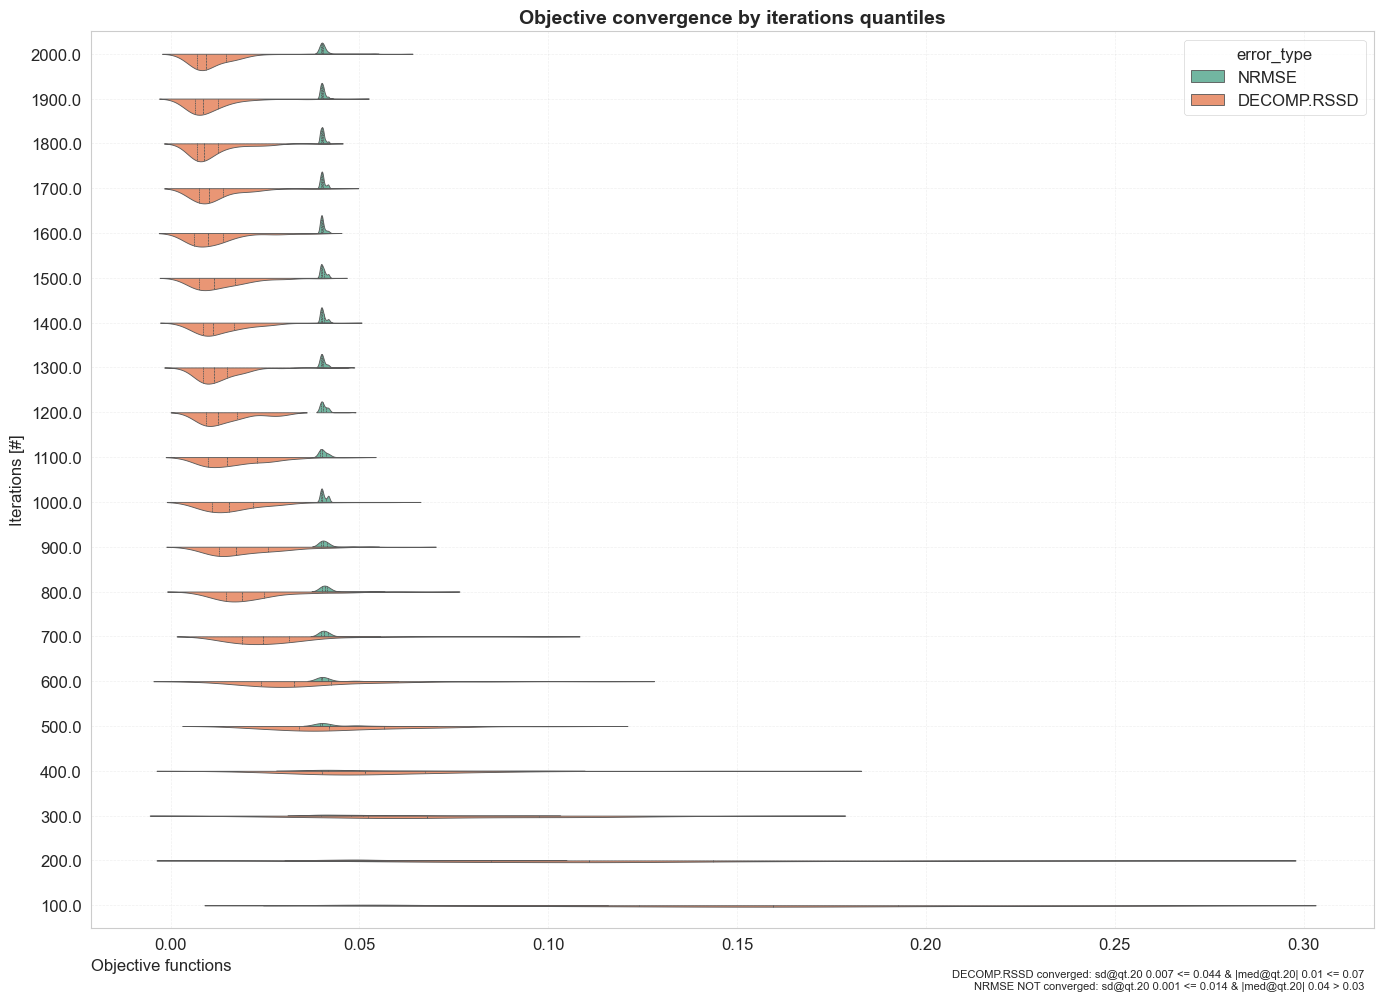

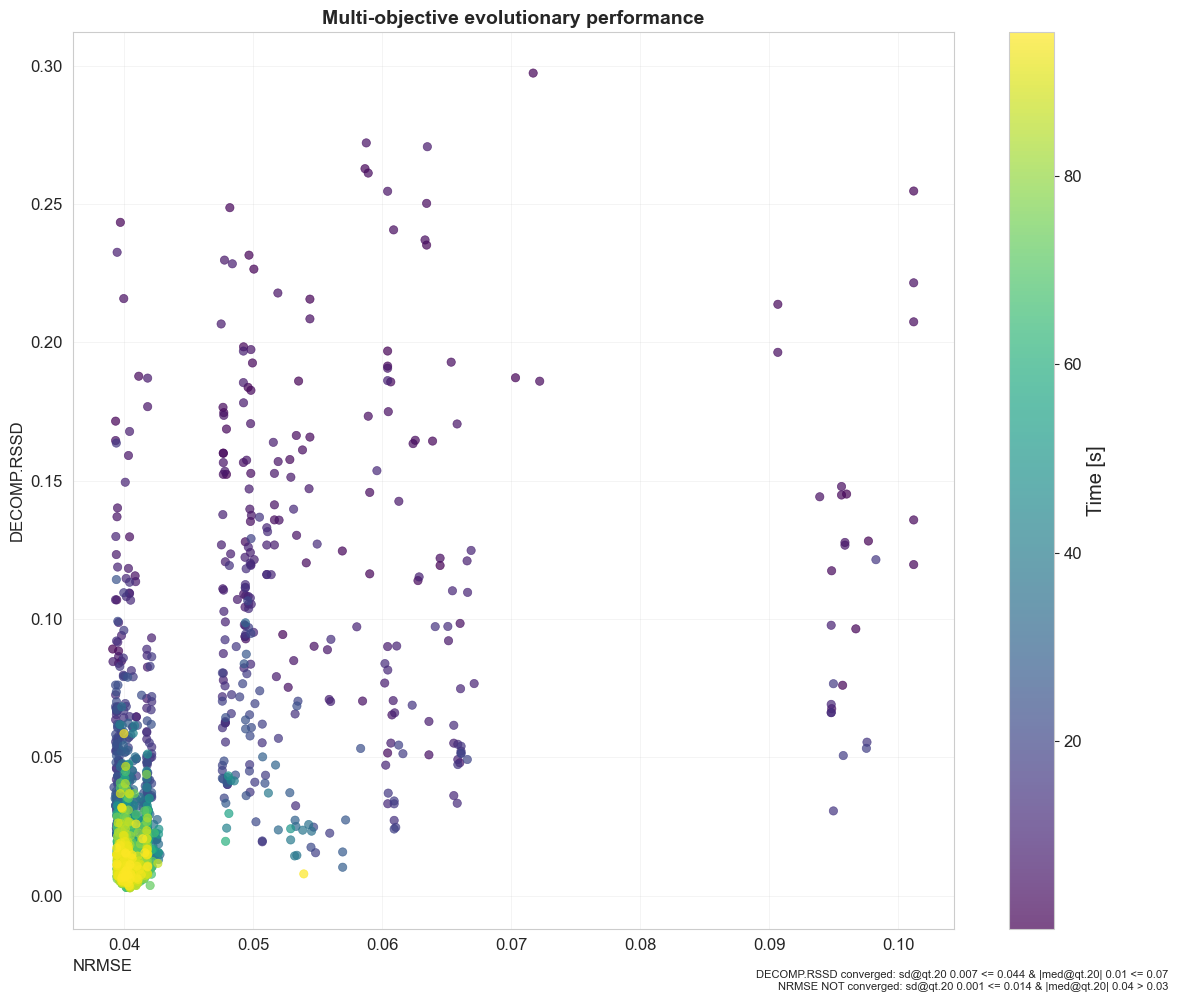

In [12]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(
    iterations=2000, trials=1
)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on x cores..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=16,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

In [13]:
from robyn.tutorials.utils.data_mapper import load_data_from_json, import_input_collect, import_output_models
%load_ext autoreload
%autoreload 2

# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/test_Pareto_50_iterations_1_trial_InputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/test_Pareto_50_iterations_1_trial_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_models = import_output_models(raw_output_models)

# Extract individual components
r_mmm_data = r_input_collect["mmm_data"]
r_featurized_mmm_data = r_input_collect["featurized_mmm_data"]
r_holidays_data = r_input_collect["holidays_data"]
r_hyperparameters = r_input_collect["hyperparameters"]

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00
Raw hyperparameters data: {'facebook_S_alphas': [0.5, 3], 'facebook_S_gammas': [0.3, 1], 'facebook_S_thetas': [0, 0.3], 'print_S_alphas': [0.5, 3], 'print_S_gammas': [0.3, 1], 'print_S_thetas': [0.1, 0.4], 'tv_S_alphas': [0.5, 3], 'tv_S_gammas': [0.3, 1], 'tv_S_thetas': [0.3, 0.8], 'search_S_alphas': [0.5, 3], 'search_S_gammas': [0.3, 1], 'search_S_thetas': [0, 0.3], 'ooh_S_alphas': [0.5, 3], 'ooh_S_gammas': [0.3, 1], 'ooh_S_thetas': [0.1, 0.4], 'newsletter_alphas': [0.5, 3], 'newsletter_gammas': [0.3, 1], 'newsletter_thetas': [0.1, 0.4], 'train_size': [0.5, 0.8]}
Debug: R output data keys: ['trial1', 'train_timestamp', 'cores', 'iterations', 'trials']
Data for trial1: Keys = ['resultCollect', 'hyperBoundNG', 'hyperBoundFixed']
Debug: resultCollect keys for trial1: ['resultHypParam', 'xDecompAgg', 'decompSpendDist', 'iter', 'elapsed.min']
D

In [14]:
# new anytree

from anytree import Node, RenderTree
from dataclasses import is_dataclass, asdict
import pandas as pd


def build_tree(data, parent_key="", limit_trials=True):
    """
    Recursively build a tree structure from a dictionary, list, or dataclass.

    Args:
        data: The data structure (dict, list, or dataclass) to traverse.
        parent_key: The base key path for nested keys.
        limit_trials: Whether to limit the output to the first trial.

    Returns:
        A tree node representing the structure of the data.
    """
    if is_dataclass(data):
        data = asdict(data)  # Convert dataclass to dictionary

    if isinstance(data, dict):
        node = Node(f"{parent_key} (Dict)")
        for key, value in data.items():
            full_key = f"{parent_key}.{key}" if parent_key else key
            child_node = build_tree(value, full_key, limit_trials)
            child_node.parent = node
        return node
    elif isinstance(data, list):
        node = Node(f"{parent_key} (List)")
        for index, item in enumerate(data):
            if limit_trials and parent_key == "trials" and index > 0:
                break
            full_key = f"{parent_key}[{index}]"
            child_node = build_tree(item, full_key, limit_trials)
            child_node.parent = node
        return node
    elif isinstance(data, pd.DataFrame):
        node = Node(f"{parent_key} (DataFrame)")
        for column in data.columns:
            dtype = data[column].dtype
            column_node = Node(f"{parent_key}.{column} (dtype: {dtype})")
            column_node.parent = node
        return node
    else:
        dtype = type(data).__name__
        return Node(f"{parent_key} (dtype: {dtype})")


# Assuming output_models and r_output_models are instances of ModelOutputs
python_tree = build_tree(output_models)
r_tree = build_tree(r_output_models)

# Visualize the trees
print("Python ModelOutputs Structure:")
for pre, fill, node in RenderTree(python_tree):
    print(f"{pre}{node.name}")

print("\nR ModelOutputs Structure:")
for pre, fill, node in RenderTree(r_tree):
    print(f"{pre}{node.name}")

Python ModelOutputs Structure:
 (Dict)
├── trials (List)
│   └── trials[0] (Dict)
│       ├── trials[0].result_hyp_param (DataFrame)
│       │   ├── trials[0].result_hyp_param.facebook_S_thetas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.facebook_S_alphas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.facebook_S_gammas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.print_S_thetas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.print_S_alphas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.print_S_gammas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.tv_S_thetas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.tv_S_alphas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.tv_S_gammas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.search_S_thetas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.search_S_alphas (dtype: float64)
│       │   ├── trials[0].result_hyp_par

In [15]:
# from anytree import Node, RenderTree
# from anytree.exporter import DotExporter
# from dataclasses import is_dataclass, asdict
# import pandas as pd


# def build_tree(data, parent_key="", limit_trials=True):
#     """
#     Recursively build a tree structure from a dictionary, list, or dataclass.

#     Args:
#         data: The data structure (dict, list, or dataclass) to traverse.
#         parent_key: The base key path for nested keys.
#         limit_trials: Whether to limit the output to the first trial.

#     Returns:
#         A tree node representing the structure of the data.
#     """
#     if is_dataclass(data):
#         data = asdict(data)  # Convert dataclass to dictionary

#     if isinstance(data, dict):
#         node = Node(parent_key)
#         for key, value in data.items():
#             full_key = f"{parent_key}.{key}" if parent_key else key
#             child_node = build_tree(value, full_key, limit_trials)
#             child_node.parent = node
#         return node
#     elif isinstance(data, list):
#         node = Node(parent_key)
#         for index, item in enumerate(data):
#             if limit_trials and parent_key == "trials" and index > 0:
#                 break
#             full_key = f"{parent_key}[{index}]"
#             child_node = build_tree(item, full_key, limit_trials)
#             child_node.parent = node
#         return node
#     elif isinstance(data, pd.DataFrame):
#         node = Node(f"{parent_key} (DataFrame: {data.shape})")
#         for column in data.columns:
#             column_node = Node(f"{parent_key}.{column}")
#             column_node.parent = node
#         return node
#     else:
#         return Node(parent_key)


# # Assuming output_models and r_output_models are instances of ModelOutputs
# python_tree = build_tree(output_models)
# r_tree = build_tree(r_output_models)

# # Visualize the trees
# print("Python ModelOutputs Structure:")
# for pre, fill, node in RenderTree(python_tree):
#     print(f"{pre}{node.name}")

# print("\nR ModelOutputs Structure:")
# for pre, fill, node in RenderTree(r_tree):
#     print(f"{pre}{node.name}")

In [16]:
import pandas as pd
import numpy as np
from typing import Dict, Any


def compare_model_values(py_output, r_output):
    """Compare key values between Python and R model outputs"""

    print("1. Basic Model Configuration Comparison:")
    basic_attrs = [
        "train_timestamp",
        "cores",
        "iterations",
        "intercept",
        "intercept_sign",
        "nevergrad_algo",
        "ts_validation",
        "add_penalty_factor",
    ]

    # Add debug prints
    print("\nDebugging attribute types:")
    for attr in basic_attrs:
        py_val = getattr(py_output, attr, None)
        r_val = getattr(r_output, attr, None)
        print(f"{attr:20s} - Python type: {type(py_val)} | R type: {type(r_val)}")
        print(f"{attr:20s} - Python value: {py_val} | R value: {r_val}")
        print("-" * 50)

    print("\n2. Trial Results Comparison (Descriptive Statistics):")
    if py_output.trials and r_output.trials:
        metrics = [
            "nrmse",
            "decomp_rssd",
            "mape",
            "rsq_train",
            "rsq_val",
            "rsq_test",
            "lambda_",
            "lambda_hp",
            "lambda_max",
            "lambda_min_ratio",
        ]
        # Convert trial results to DataFrames
        py_trials_df = pd.DataFrame(
            [
                {metric: getattr(trial, metric, np.nan) for metric in metrics}
                for trial in py_output.trials
            ]
        )

        # Aggregate R trial metrics
        r_trials_df = pd.DataFrame(
            [
                {
                    metric: getattr(trial, metric, pd.Series([np.nan])).mean()
                    for metric in metrics
                }
                for trial in r_output.trials
            ]
        )
        # Ensure R trial data is numeric
        r_trials_df = r_trials_df.apply(pd.to_numeric, errors="coerce")
        # Calculate descriptive statistics
        py_desc = py_trials_df.describe()
        r_desc = r_trials_df.describe()
        # Print descriptive statistics
        print("\nPython Trial Descriptive Statistics:")
        print(py_desc)
        print("\nR Trial Descriptive Statistics:")
        print(r_desc)
        # Calculate and print differences
        diff_desc = py_desc - r_desc
        print("\nDifference in Descriptive Statistics:")
        print(diff_desc)

    print("\n3. Hyperparameter Comparison:")
    if hasattr(py_output, "hyper_updated") and hasattr(r_output, "hyper_updated"):
        py_hyper = py_output.hyper_updated
        r_hyper = r_output.hyper_updated

        # Find all unique keys
        all_keys = set(py_hyper.keys()) | set(r_hyper.keys())

        print("\nHyperparameter Values:")
        print(f"{'Parameter':30s} {'Python':>15s} {'R':>15s} {'Diff':>15s}")
        print("-" * 75)

        for key in sorted(all_keys):
            py_val = py_hyper.get(key, "N/A")
            r_val = r_hyper.get(key, "N/A")

            if isinstance(py_val, (int, float)) and isinstance(r_val, (int, float)):
                diff = abs(py_val - r_val)
                print(f"{key:30s} {py_val:15.6f} {r_val:15.6f} {diff:15.6f}")
            else:
                print(f"{key:30s} {str(py_val):15s} {str(r_val):15s} {'N/A':>15s}")

    print("\n4. Data Shape Comparison:")
    data_attrs = ["all_result_hyp_param", "all_x_decomp_agg", "all_decomp_spend_dist"]

    for attr in data_attrs:
        py_shape = getattr(py_output, attr).shape if hasattr(py_output, attr) else None
        r_shape = getattr(r_output, attr).shape if hasattr(r_output, attr) else None
        print(f"{attr:20s} - Python shape: {py_shape} | R shape: {r_shape}")

    print("\n5. Total Effect and Effect Share Comparison:")
    if py_output.trials and r_output.trials:
        for i, (py_trial, r_trial) in enumerate(zip(py_output.trials, r_output.trials)):
            print(f"\nTrial {i+1}:")
            # Extract decomp_spend_dist DataFrames
            py_decomp_spend_dist = getattr(
                py_trial, "decomp_spend_dist", pd.DataFrame()
            )
            r_decomp_spend_dist = getattr(r_trial, "decomp_spend_dist", pd.DataFrame())
            # Check if the DataFrames are not empty
            if not py_decomp_spend_dist.empty and not r_decomp_spend_dist.empty:
                # Compare total effect
                py_total_effect = py_decomp_spend_dist.get(
                    "xDecompAgg", pd.Series([np.nan])
                ).sum()
                r_total_effect = r_decomp_spend_dist.get(
                    "xDecompAgg", pd.Series([np.nan])
                ).sum()
                total_effect_diff = abs(py_total_effect - r_total_effect)
                print(
                    f"Total Effect - Python: {py_total_effect:.6f}, R: {r_total_effect:.6f}, Diff: {total_effect_diff:.6f}"
                )
                # Compare effect share
                py_effect_share = py_decomp_spend_dist.get(
                    "effect_share", pd.Series([np.nan])
                ).sum()
                r_effect_share = r_decomp_spend_dist.get(
                    "effect_share", pd.Series([np.nan])
                ).sum()
                effect_share_diff = abs(py_effect_share - r_effect_share)
                print(
                    f"Effect Share - Python: {py_effect_share:.6f}, R: {r_effect_share:.6f}, Diff: {effect_share_diff:.6f}"
                )
            else:
                print(
                    "Decomposition spend distribution data is missing for this trial."
                )


# Run the comparison
print("Starting detailed value comparison...\n")
compare_model_values(output_models, r_output_models)

Starting detailed value comparison...

1. Basic Model Configuration Comparison:

Debugging attribute types:
train_timestamp      - Python type: <class 'str'> | R type: <class 'str'>
train_timestamp      - Python value: 2024-12-03 01:17:27 | R value: 2024-11-29 20:22:31
--------------------------------------------------
cores                - Python type: <class 'int'> | R type: <class 'int'>
cores                - Python value: 10 | R value: 9
--------------------------------------------------
iterations           - Python type: <class 'int'> | R type: <class 'int'>
iterations           - Python value: 2000 | R value: 50
--------------------------------------------------
intercept            - Python type: <class 'bool'> | R type: <class 'bool'>
intercept            - Python value: True | R value: True
--------------------------------------------------
intercept_sign       - Python type: <class 'str'> | R type: <class 'str'>
intercept_sign       - Python value: non_negative | R value: 

/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_81499/3835541963.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  py_desc = py_trials_df.describe()
/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_81499/3835541963.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  py_desc = py_trials_df.describe()
/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_81499/3835541963.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  py_desc = py_trials_df.describe()
/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_81499/3835541963.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  py

In [17]:
# Assuming r_output_models is an instance of ModelOutputs
convergence_data = r_output_models.convergence

# Accessing attributes of ConvergenceData
moo_distrb_plot = convergence_data.moo_distrb_plot
moo_cloud_plot = convergence_data.moo_cloud_plot
errors = convergence_data.errors
conv_msg = convergence_data.conv_msg

# Example: Print the convergence messages
print("Convergence Messages:", conv_msg)

Convergence Messages: ['DECOMP.RSSD NOT converged: sd@qt.20 0.033 > 0.021 & |med@qt.20| 0.73 > 0.68', 'NRMSE NOT converged: sd@qt.20 0.12 > 0.085 & |med@qt.20| 0.25 > 0.14']


In [18]:
from PIL import Image
import io
import binascii
from typing import Optional

# Assuming convergence_data is an instance of ConvergenceData
# and contains hexadecimal strings of image data


def display_image(data: Optional[str]):
    if data:
        # If data is a list, join it into a single string
        if isinstance(data, list):
            data = "".join(data)

        # Convert hexadecimal string to binary data
        binary_data = binascii.unhexlify(data)

        # Open the image using PIL
        image = Image.open(io.BytesIO(binary_data))

        # Display the image
        image.show()
    else:
        print("No image data available.")


# print("moo distrb plot:", type(moo_distrb_plot))
# print("first 10 elements in moo distrb plot:", moo_distrb_plot[0:10])
# print("moo cloud plot:", type(moo_cloud_plot))
# Assuming convergence_data is an instance of ConvergenceData
# Display the moo_distrb_plot
# display_image(convergence_data.moo_distrb_plot)
# # Display the moo_cloud_plot
# display_image(convergence_data.moo_cloud_plot)

In [19]:
# # Function to print model output summary
# def print_model_output_summary(model_name, model):
#     print(f"\n{model_name} Model Output Summary:")
#     print(f"Number of trials: {len(model.trials)}")
#     print(
#         f"Average models per trial: {len(model.all_result_hyp_param) / len(model.trials)}"
#     )
#     print(f"Total unique models: {len(model.all_result_hyp_param['sol_id'].unique())}")

#     print("\nMetrics Distribution:")
#     metrics_df = model.all_result_hyp_param[["nrmse", "decomp.rssd", "mape"]]
#     print(metrics_df.describe())

#     # Additional validation to debug model output
#     print("\nColumns in result_hyp_param:")
#     print(model.all_result_hyp_param.columns.tolist())

#     print("\nSample rows of metrics:")
#     print(model.all_result_hyp_param[["sol_id", "nrmse", "decomp.rssd", "mape"]].head())

#     # Show shape of result dataframes
#     print("\nDataFrame Shapes:")
#     print(f"result_hyp_param: {model.all_result_hyp_param.shape}")
#     print(f"x_decomp_agg: {model.all_x_decomp_agg.shape}")
#     print(f"decomp_spend_dist: {model.all_decomp_spend_dist.shape}")


# # Print summaries for both output_models and r_output_models
# print_model_output_summary("Python Output Models", output_models)
# print_model_output_summary("R Output Models", r_output_models)

In [20]:
# def print_data_structure(data):
#     print("Columns:", data.columns.tolist())
#     print("\nFirst row:", data.iloc[0].to_dict())
#     print("\nShape:", data.shape)


# # Assuming you want to print the structure for the first trial
# first_trial_r = r_output_models.trials[0].decomp_spend_dist
# first_trial_python = output_models.trials[0].decomp_spend_dist

# print("R exported data structure:")
# print_data_structure(first_trial_r)

# # With Python calculated data
# print("\nPython calculated data structure:")
# print_data_structure(first_trial_python)